<a href="https://colab.research.google.com/github/WRFitch/fyp/blob/main/src/fyp_ai_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI data analysis

## Notes on Use. 
Because fastai can be a bit silly, restart runtime when you have to. Yes, it's very annoying. 

### Setup
- Install & import necessary libraries

In [ ]:
# Sometimes the colab fastai version can be wrong, so we reinstall with no cache
# uninstalling, reinstalling, and restarting runtime should fix any major issues. 
!pip uninstall -y fastai
!pip install -U --no-cache-dir fastai

In [9]:
# TODO clean up imports - I can't seriously need all this
import os
import numpy as np
import pandas as pd

from fastai import *
from fastai.tabular import *
from fastai.vision import *
from fastai.vision.all import *
from google.colab import drive
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive')

#print(fastai.__version__)

In [11]:
drive_path = "/content/drive/MyDrive/"
png_dir = f"{drive_path}img_export/png"

CO_band = 'CO_column_number_density'
HCHO_band = 'tropospheric_HCHO_column_number_density'
NO2_band = 'tropospheric_NO2_column_number_density'
O3_band = 'O3_column_number_density'
SO2_band = 'SO2_column_number_density'
CH4_band = 'CH4_column_volume_mixing_ratio_dry_air'
ghg_bands = [CO_band, HCHO_band, NO2_band, O3_band, SO2_band, CH4_band]

lon = "longitude"
lat = "latitude"

In [12]:
# Import data from google drive 
# This is getting really slow. Is there too much data? If so, slice to only use every tenth image so we still get a 
# decently stratified set. 
path = f"{drive_path}img_export"
imgs = get_image_files(png_dir)

In [13]:
len(imgs)

8349

### Data Setup

#### Sort Dataframes

In [14]:
# Parse CSVs into pandas dataframes
# TODO rewrite so we aren't deleting columns directly - do it properly! Incorporate these into one csv export in the 
#      output pipeline 
co_df = pd.read_csv(f"{path}/{CO_band}.csv")
del co_df[".geo"]
hcho_df = pd.read_csv(f"{path}/{HCHO_band}.csv")
del hcho_df[".geo"]
no2_df = pd.read_csv(f"{path}/{NO2_band}.csv")
del no2_df[".geo"]
o3_df = pd.read_csv(f"{path}/{O3_band}.csv")
del o3_df[".geo"]
so2_df = pd.read_csv(f"{path}/{SO2_band}.csv")
del so2_df[".geo"]
ch4_df = pd.read_csv(f"{path}/{CH4_band}.csv")
del ch4_df[".geo"]

In [7]:
# Incorporate individual csvs into one ghg dataframe. Badly. 
# TODO fix this so we aren't repeating the same thing over and over
mrg_params = ['longitude', 'latitude', 'system:index']
# somehow this means "intersect". We're taking the intersect so we know we have common values. 
mrg_type = 'inner'

intersect = pd.merge(so2_df, ch4_df, how=mrg_type, on=mrg_params)
intersect = pd.merge(intersect, co_df, how=mrg_type, on=mrg_params)
intersect = pd.merge(intersect, hcho_df, how=mrg_type, on=mrg_params)
intersect = pd.merge(intersect, no2_df, how=mrg_type, on=mrg_params)
intersect = pd.merge(intersect, o3_df, how=mrg_type, on=mrg_params)

print(intersect.shape)
intersect.iloc[0:4] 

(4414, 9)


,system:index,SO2_column_number_density,longitude,latitude,CH4_column_volume_mixing_ratio_dry_air,CO_column_number_density,tropospheric_HCHO_column_number_density,tropospheric_NO2_column_number_density,O3_column_number_density
0,0_0,0.000299,-0.795009,51.109648,1846.019699,0.032668,0.000042,0.000045,0.143542
1,0_1,0.000278,-0.786026,51.109648,1845.944668,0.032708,0.000043,0.000046,0.143542
2,0_2,0.000290,-0.777043,51.109648,1845.243287,0.032764,0.000043,0.000046,0.143526
3,0_3,0.000298,-0.768060,51.109648,1844.739419,0.032754,0.000045,0.000045,0.143494


In [ ]:
raw_ghg_df = intersect.copy()

for index, row in intersect.iterrows():
  coords = (row.longitude, row.latitude)
  #print(coords)
  if not imgExported(coords):
    print(f"dropping {getFilepath(coords)} from row {index}")
    # TODO implement this in a way that doesn't suck. 
    raw_ghg_df = raw_ghg_df.drop(index=index)

raw_ghg_df.iloc[0:10]

In [65]:
print(intersect.shape)
print(raw_ghg_df.shape)
raw_ghg_df.iloc[0:4] 

(4414, 9)
(1886, 9)


,system:index,SO2_column_number_density,longitude,latitude,CH4_column_volume_mixing_ratio_dry_air,CO_column_number_density,tropospheric_HCHO_column_number_density,tropospheric_NO2_column_number_density,O3_column_number_density
134,0_134,0.000267,-0.795009,51.118631,1846.586718,0.032733,0.000043,0.000045,0.143586
135,0_135,0.000249,-0.786026,51.118631,1846.299177,0.032700,0.000044,0.000045,0.143580
136,0_136,0.000274,-0.777043,51.118631,1845.862789,0.032723,0.000043,0.000045,0.143549
137,0_137,0.000310,-0.768060,51.118631,1843.941185,0.032713,0.000042,0.000045,0.143517


In [66]:
# Normalise ghg numbers so they can be more easily predicted by the network, and fit into a manageable y_range 
# TODO I haven't even implemented this yet and I know it's a hack. Refactor to not suck. 
ghg_df = raw_ghg_df.copy()
ghg_df[SO2_band] = ghg_df[SO2_band].apply(lambda x: x*10000)
ghg_df[CH4_band] = ghg_df[CH4_band].apply(lambda x: x/1000)
ghg_df[CO_band] = ghg_df[CO_band].apply(lambda x: x*100)
ghg_df[HCHO_band] = ghg_df[HCHO_band].apply(lambda x: x*100000)
ghg_df[NO2_band] = ghg_df[NO2_band].apply(lambda x: x*100000)
ghg_df[O3_band] = ghg_df[O3_band].apply(lambda x: x*10)

raw_ghg_df.iloc[0:4]
ghg_df.iloc[0:4]

,system:index,SO2_column_number_density,longitude,latitude,CH4_column_volume_mixing_ratio_dry_air,CO_column_number_density,tropospheric_HCHO_column_number_density,tropospheric_NO2_column_number_density,O3_column_number_density
134,0_134,2.672824,-0.795009,51.118631,1.846587,3.273310,4.340454,4.529627,1.435862
135,0_135,2.486536,-0.786026,51.118631,1.846299,3.270005,4.446930,4.546964,1.435798
136,0_136,2.740308,-0.777043,51.118631,1.845863,3.272315,4.323521,4.499055,1.435488
137,0_137,3.104459,-0.768060,51.118631,1.843941,3.271314,4.237725,4.479952,1.435175


#### Sort Data Import Methods

In [28]:
# get filename from filepath, remove file extension and split into longitude and latitude. 
def getCoords(img_path):
  return list(map(float, img_path.split("/")[-1][0:-4].split("_")))

def getFilepath(coords):
  return f"{png_dir}/{coords[0]}_{coords[1]}.png"

def imgExported(coords):
  return os.path.isfile(getFilepath(coords))

# Get the row from the given dataframe at the given coordinates.
# We have to define rounded precision because floats suck. There should be a better way of doing this...
def getValAt(coords, df, prec=10):
  return df.loc[(round(df["longitude"], prec) == round(coords[0], prec)) & \
                (round(df["latitude" ], prec) == round(coords[1], prec))]

# it's short, but it's still trashy. 
def get_ghgs(img_path):
  coords = getCoords(str(img_path))
  ghgs = getValAt(coords, ghg_df)
  concentrations = ghgs[ghg_bands]
  if len(concentrations) == 0 : return None 
  if None in concentrations: return None
  # There has to be a cleaner way to do this. Iterating through and then only getting the first line? really? 
  return [tuple(x) for x in concentrations.to_numpy()][0]

def getGhgsAsArr(img_path):
  return np.array(get_ghgs(img_path))

# Define a label function for image data by getting centroid long and lat from image filename, then accessing the 
# corresponding GHG values from the pandas dataframe defined above. 
def get_so2(img_path):
  coords = getCoords(str(img_path))
  so2 = getValAt(coords, so2_df)
  # AI is currently confused by the very tiny values of SO2 - for now, multiplying by 10k to get a decent predictor. 
  return so2.at[so2.index[-1],SO2_band] * 10000
  

In [19]:
count = 0 
for root, dirs, files in os.walk(png_dir, topdown=True):
    for name in files:
      fullpath = os.path.join(root, name)
      temp_ghg = get_ghgs(fullpath)
      if temp_ghg != None and len(temp_ghg) == 6:
        #print(temp_ghg)
        count += 1

print(count)

1886


In [20]:
# TODO update transforms - Duplicating the dataset through each horz flip, vert flip and 90 degree rotation may be 
#      valuable. 
# TODO remove transform if not duplicating. It reduces data validity, without any real benefit.
so2Block = DataBlock(
    blocks = (ImageBlock, RegressionBlock),
    get_items = get_image_files,
    get_y = get_so2,
    item_tfms = (Resize(224),
                 DihedralItem)
)

so2_dl = so2Block.dataloaders(png_dir)

In [21]:
# Checks the image is in the dataframe and can therefore be used
def imgIsInDf(path):
  # Probably a faster way to do this
  val = get_ghgs(path)
  if val == None: return False 
  if len(val) == 6: return True 
  return False

def get_ghg_imgs(path):
  return get_image_files(path).filter(imgIsInDf)

In [67]:
# TODO research multivariate regression in fastai
# TODO implement multiple transforms pipeline
ghg_block = DataBlock(
    blocks = (ImageBlock, RegressionBlock, RegressionBlock, RegressionBlock, RegressionBlock, RegressionBlock, RegressionBlock),
    get_items = get_ghg_imgs, 
    get_y = getGhgsAsArr,
    item_tfms = Resize(224)
)

ghg_dl = ghgBlock.dataloaders(png_dir)

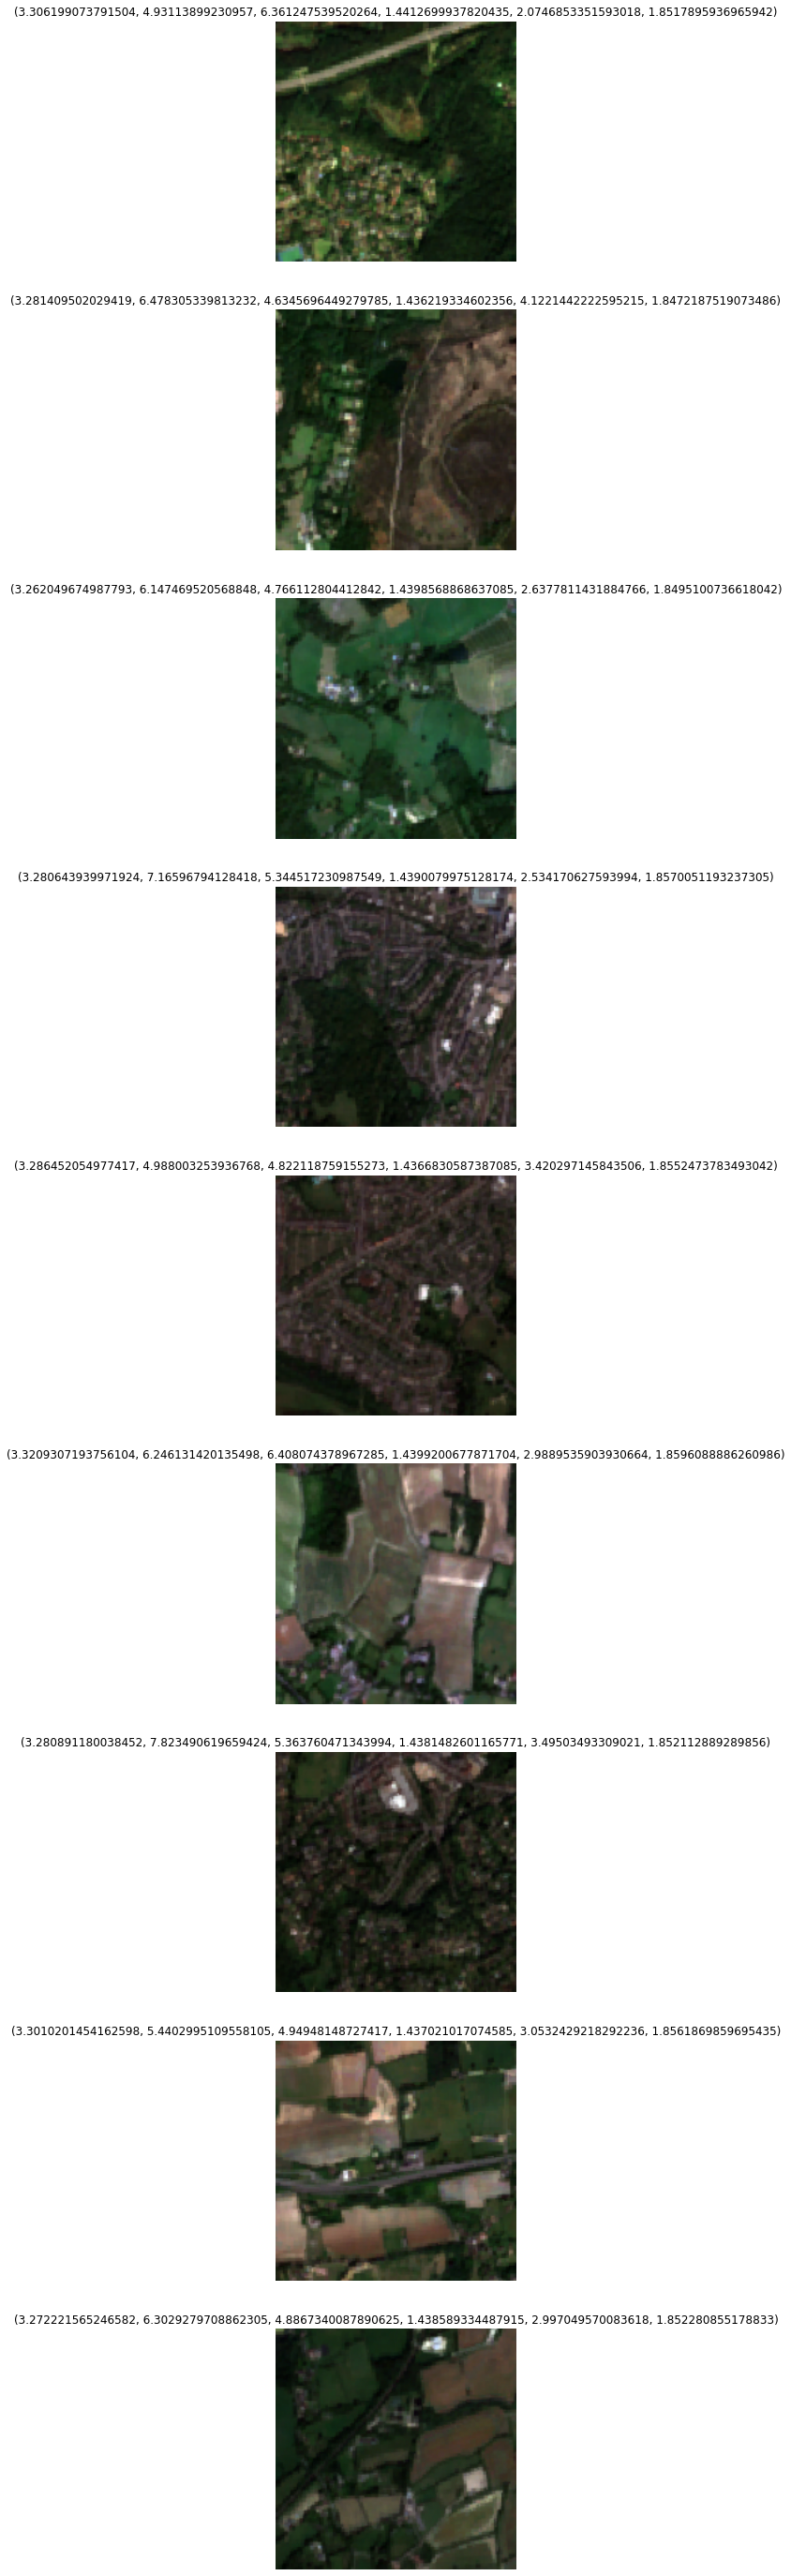

In [68]:
ghg_dl.show_batch(nrows=9, max_n=9, figsize = (50,50))

In [ ]:
ghg_block.summary(f"{path}/png")

## Training

### Image Recognition and Feature Extraction. 

- Train image-based predictor to guess greenhouse gas concentrations based on 1km square of land. 
  - Transfer an ImageNet predictor to work top-down
  - Start by predicting one ghg and expand from there
- Use image predictor to extract a basic feature set by slicing the network at different points. The idea is to limit the amount of data going into the tabular recommender, while transferring as much useful data as possible. We want to implicitly extract GHG-emitting features of each image without losing any detail, as a form of convolutional preprocessing. 


In [69]:
# uses a regression approach.
# TODO figure out how y_range works - it appears to just be a simple output range, but I can't be sure. 
# TODO analyse metrics. Really it doesn't seem to matter so long as everything is evaluated equally, but I'd like to be 
#      sure - ask Allan on Monday. 
# TODO Further experimentation with resnet size is necessary. 34 provides _ok_ predictions, longer is usually better but
#      it takes longer to train. While I'm iterating on design, performance is necessary. Once I'm at a stage where I 
#      can export my model and use it as is, I'll take the time to train a much larger network. 
# TODO experiment with y_range - a np.array with different y_ranges might work? 
learn = cnn_learner(ghg_dl, resnet34, y_range=(0, 10),  metrics=rmse)

In [70]:
name = "learner test"
learn.save(name)

Path('models/learner test.pth')

In [79]:
learn.load(name)

SuggestedLRs(lr_min=0.05248074531555176, lr_steep=0.019054606556892395)

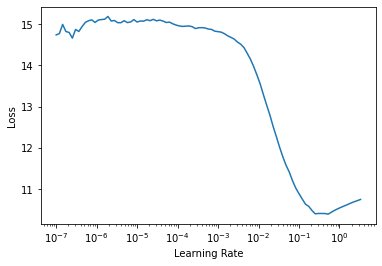

In [80]:
# Experimenting if this changes as we fine-tune the model 
learn.lr_find()

In [81]:
lr = 0.02

In [82]:
# epochs = 4
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,_rmse,time
0,11.203818,6.825808,2.612625,00:11


epoch,train_loss,valid_loss,_rmse,time
0,3.271525,2.260424,1.503471,00:12
1,2.031044,0.577494,0.759930,00:12
2,1.383105,0.342254,0.585025,00:12


In [83]:
# Saving mid-training, so I can figure out a decent training pathway
learn.save("mid-training")

Path('models/mid-training.pth')

In [84]:
learn.load("mid-training")

In [86]:
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,_rmse,time
0,0.611126,0.596643,0.772427,00:12


epoch,train_loss,valid_loss,_rmse,time
0,0.602592,10.496698,3.239861,00:12
1,0.781389,2.221399,1.490436,00:12
2,0.725963,0.499185,0.706530,00:12


In [ ]:
learn.save("fine-tuning")

In [ ]:
learn.load("fine-tuning")

In [77]:
learn.fine_tune(1, lr)

epoch,train_loss,valid_loss,_rmse,time
0,0.758477,0.927088,0.962854,00:11


epoch,train_loss,valid_loss,_rmse,time
0,0.924309,0.377713,0.614583,00:12


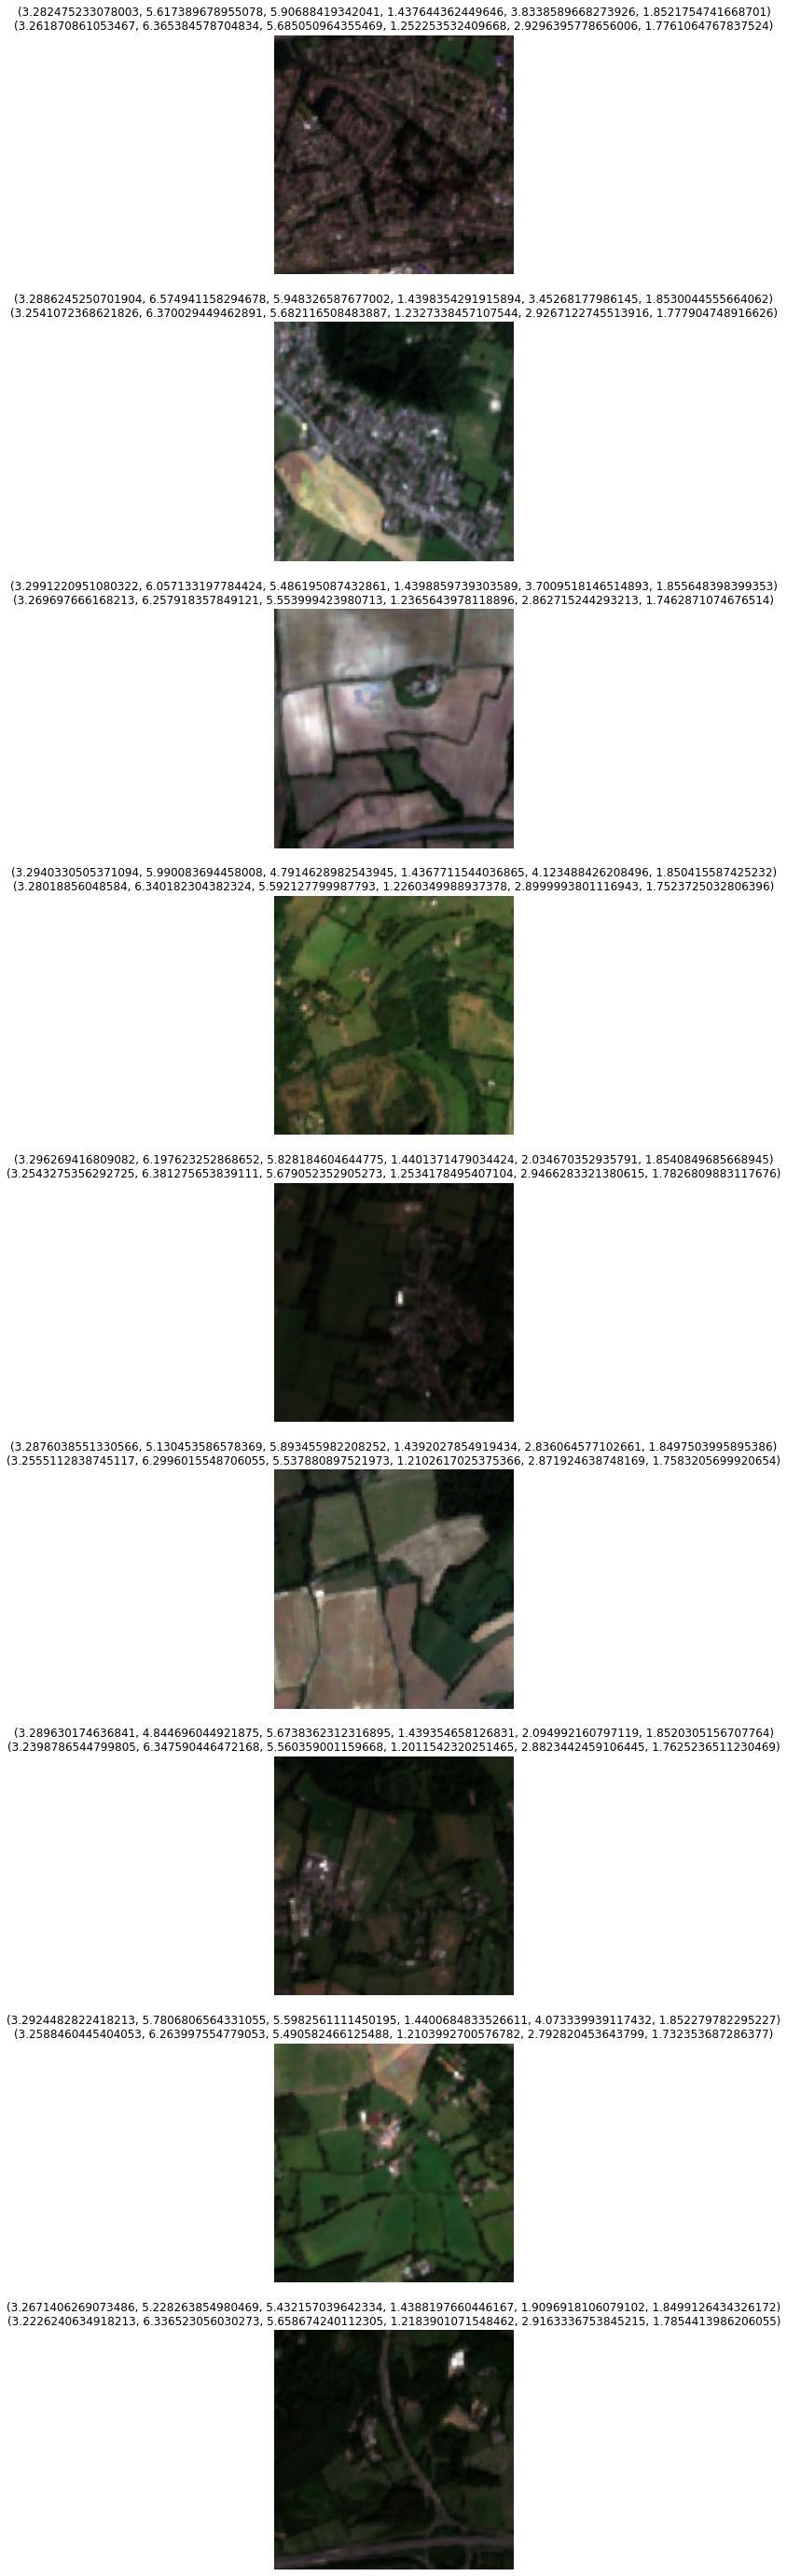

In [76]:
learn.show_results(ds_idx=1, nrows=9, max_n=9, figsize = (50,50))

#### Notes on Image Predictions

A lower learning rate appears to cause slower training with more sophisticated conclusions. Sophistication also appears to arise from a deeper network, but I'm hitting a wall at roughly 0.6 rmse.

---

Currently, the networks are having some trouble defining more subtle characteristics of the images, which shows some flaws in my work. The network will need some supplemental information to accurately predict the greenhouse gas at this point. This may include the following:
- **Latitude/Longitude.** Geography may affect predictions - all the images in my current dataset are near London, meaning they have far more greenhouse gases than most places. To encode a knowledge of city geography into a neural net may take some work...
- **Property Value.** How valuable is this land? This could go some way to encoding city dynamics, as well as explaining where the land might be. If land is rural, but valuable, it's likely to be near major cities or airports. 
- **Nearby GHG Values.** Combined with wind direction, an understanding of source & direction of airflow may describe how areas inherit ghg's from elsewhere. An example of this would be the high concentration of NO<sub>2</sub> north of Heathrow Airport, which may be caused by common flight patterns heading north. 
- **Wind Direction.** See above. 
- **Land Use.** Depending on detail, this may help alleviate the "grey field/massive factory" issue described in my log. By proving that certain areas are rural, residential, or industrial, we can limit errors based on inferring purely visual information. If we can specifically define what a large grey box is doing, we can also come to more developed conclusions about its purpose. A recycling center, an oil refinery, and a brewery may all look similar from above, but information about what they _are_ will limit a neural network getting confused. 
- **Population Density/Economic Output.** This will work in a similar way to property value, where we can predict human activity and its effects on greenhouse gases. Economic output may have a complex relationship to GHG emissions that cannot be easily represented, depending on the form of industry. For example, an eco-tourist attraction may rely on its low carbon footprint for survival, whereas a petrol station relies on high carbon ouput. 
- **Land Height**

Effectively, this network recognises certain features of high-GHG land. Depending on sophistication, this may include airports, power plants, or other rare features, as well as recognising different types of wilderness or residential districts. This will be used to extract a feature set for a tabular recommender, which can then be used to find more accurate readings. 

### Tabular Recommender Training